In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_classification, make_moons, load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [14]:
# FlexibleNeuralNet: оновлена версія
# Додає підтримку: кількох шарів, softmax, різних активацій, регуляризації, ранньої зупинки, mini-batch

import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

class NeuralNet:
    def __init__(self,
                 hidden_layers=[20],
                 hidden_activations=['relu'],
                 output_activation='sigmoid',
                 learning_rate=0.01,
                 num_iter=30000,
                 normalize=True,
                 regularization=None,
                 lambda_reg=0.01,
                 early_stopping=False,
                 patience=1000,
                 batch_size=None):

        self.hidden_layers = hidden_layers
        self.hidden_activations = hidden_activations
        self.output_activation = output_activation
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.normalize = normalize
        self.regularization = regularization
        self.lambda_reg = lambda_reg
        self.early_stopping = early_stopping
        self.patience = patience
        self.batch_size = batch_size

    # --- Активаційні функції ---
    def _sigmoid(self, Z): return 1 / (1 + np.exp(-Z))
    def _relu(self, Z): return np.maximum(0, Z)
    def _tanh(self, Z): return np.tanh(Z)
    def _softmax(self, Z):
        expZ = np.exp(Z - np.max(Z, axis=0, keepdims=True))
        return expZ / np.sum(expZ, axis=0, keepdims=True)

    def _activation(self, Z, kind):
        return {
            'sigmoid': self._sigmoid,
            'relu': self._relu,
            'tanh': self._tanh,
            'softmax': self._softmax
        }[kind](Z)

    def _activation_derivative(self, A, kind):
        if kind == 'sigmoid': return A * (1 - A)
        if kind == 'relu': return (A > 0).astype(float)
        if kind == 'tanh': return 1 - A ** 2
        return None  # softmax derivative handled separately

    # --- Ініціалізація вагів ---
    def _initialize_parameters(self, layer_dims):
        self.parameters = {}
        for l in range(1, len(layer_dims)):
            self.parameters[f"W{l}"] = np.random.randn(layer_dims[l], layer_dims[l - 1]) * 0.01
            self.parameters[f"b{l}"] = np.zeros((layer_dims[l], 1))

    def _normalize(self, X, mean=None, std=None):
        n = X.shape[0]
        if mean is None:
            mean = np.mean(X, axis=1).reshape((n, 1))
        if std is None:
            std = np.std(X, axis=1).reshape((n, 1))
        return (X - mean) / std, mean, std

    # --- Forward pass ---
    def _forward(self, X):
        cache = {'A0': X}
        A = X
        L = len(self.hidden_layers) + 1
        all_activations = self.hidden_activations + [self.output_activation]

        for l in range(1, L + 1):
            W = self.parameters[f"W{l}"]
            b = self.parameters[f"b{l}"]
            Z = W @ A + b
            A = self._activation(Z, all_activations[l - 1])
            cache[f"Z{l}"] = Z
            cache[f"A{l}"] = A

        return A, cache

    # --- Backward pass ---
    def _backward(self, X, Y, cache):
        grads = {}
        m = X.shape[1]
        L = len(self.hidden_layers) + 1
        all_activations = self.hidden_activations + [self.output_activation]

        A_final = cache[f"A{L}"]
        dA = A_final - Y if self.output_activation == 'softmax' else (A_final - Y)

        for l in reversed(range(1, L + 1)):
            A_prev = cache[f"A{l - 1}"]
            Z = cache[f"Z{l}"]
            A = cache[f"A{l}"]

            if self.output_activation == 'softmax' and l == L:
                dZ = dA
            else:
                dZ = dA * self._activation_derivative(A, all_activations[l - 1])

            grads[f"dW{l}"] = (1 / m) * dZ @ A_prev.T
            grads[f"db{l}"] = (1 / m) * np.sum(dZ, axis=1, keepdims=True)

            if self.regularization == 'l2':
                grads[f"dW{l}"] += self.lambda_reg * self.parameters[f"W{l}"] / m
            elif self.regularization == 'l1':
                grads[f"dW{l}"] += self.lambda_reg * np.sign(self.parameters[f"W{l}"]) / m

            dA = self.parameters[f"W{l}"].T @ dZ

        return grads

    # --- Update parameters ---
    def _update_parameters(self, grads):
        L = len(self.hidden_layers) + 1
        for l in range(1, L + 1):
            self.parameters[f"W{l}"] -= self.learning_rate * grads[f"dW{l}"]
            self.parameters[f"b{l}"] -= self.learning_rate * grads[f"db{l}"]

    def _compute_cost(self, A, Y):
        m = Y.shape[1]
        if self.output_activation == 'softmax':
            logprobs = np.sum(Y * np.log(A + 1e-8), axis=0)
        else:
            logprobs = Y * np.log(A + 1e-8) + (1 - Y) * np.log(1 - A + 1e-8)
        cost = -np.mean(logprobs)
        return cost

    def fit(self, X_vert, Y_vert, print_cost=True):
        X, Y = X_vert.T, Y_vert.T
        if self.normalize:
            X, self._mean, self._std = self._normalize(X)

        input_dim = X.shape[0]
        output_dim = Y.shape[0] if len(Y.shape) > 1 else 1
        layer_dims = [input_dim] + self.hidden_layers + [output_dim]

        self._initialize_parameters(layer_dims)

        best_cost = float('inf')
        patience_counter = 0
        costs = []

        for i in range(self.num_iter):
            if self.batch_size:
                X, Y = shuffle(X.T, Y.T)
                X, Y = X.T, Y.T
                for start in range(0, X.shape[1], self.batch_size):
                    end = start + self.batch_size
                    A, cache = self._forward(X[:, start:end])
                    grads = self._backward(X[:, start:end], Y[:, start:end], cache)
                    self._update_parameters(grads)
            else:
                A, cache = self._forward(X)
                grads = self._backward(X, Y, cache)
                self._update_parameters(grads)

            if i % 100 == 0:
                A, _ = self._forward(X)
                cost = self._compute_cost(A, Y)
                costs.append(cost)
                if print_cost:
                    print(f"{i}-th iteration: cost = {cost}")

                if self.early_stopping:
                    if cost < best_cost:
                        best_cost = cost
                        patience_counter = 0
                    else:
                        patience_counter += 100
                        if patience_counter >= self.patience:
                            print("Early stopping triggered.")
                            break

        if print_cost:
            plt.plot(costs)
            plt.title("Cost over iterations")
            plt.xlabel("Iteration (per 100)")
            plt.ylabel("Cost")
            plt.show()

    def predict(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self._normalize(X, self._mean, self._std)
        A, _ = self._forward(X)
        return np.argmax(A, axis=0) if self.output_activation == 'softmax' else (A > 0.5).astype(int).flatten()

    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self._normalize(X, self._mean, self._std)
        A, _ = self._forward(X)
        return A.T


In [15]:
def evaluate_classification(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    confusion = confusion_matrix(y_true, y_pred)
    return accuracy, report, confusion

In [16]:
def plot_decision_boundary(model, X, y, resolution=0.01):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), edgecolors='k', cmap=plt.cm.coolwarm)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title('Decision Boundary')

# Тест

=== Dataset: make_classification ===
0-th iteration: cost = 0.6931461352586519
100-th iteration: cost = 0.6930655361128344
200-th iteration: cost = 0.6930426986614165
300-th iteration: cost = 0.6930360772844917
400-th iteration: cost = 0.6930340367797768
500-th iteration: cost = 0.6930333417097415
600-th iteration: cost = 0.6930330140523131
700-th iteration: cost = 0.6930327765682854
800-th iteration: cost = 0.6930325475256631
900-th iteration: cost = 0.6930323095584506
1000-th iteration: cost = 0.6930320612734389
1100-th iteration: cost = 0.693031797799532
1200-th iteration: cost = 0.6930315159307291
1300-th iteration: cost = 0.6930312120202988
1400-th iteration: cost = 0.6930308830112386
1500-th iteration: cost = 0.6930305255977689
1600-th iteration: cost = 0.6930301361904511
1700-th iteration: cost = 0.6930297110144079
1800-th iteration: cost = 0.6930292441543144
1900-th iteration: cost = 0.6930287312220769
2000-th iteration: cost = 0.6930281661296069
2100-th iteration: cost = 0.693

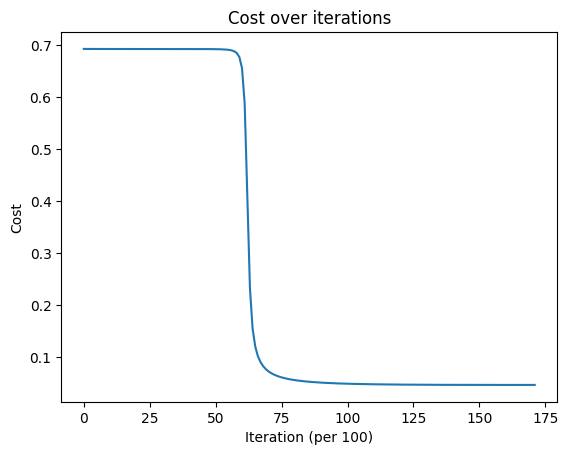

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        47
           1       1.00      0.96      0.98        53

    accuracy                           0.98       100
   macro avg       0.98      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100



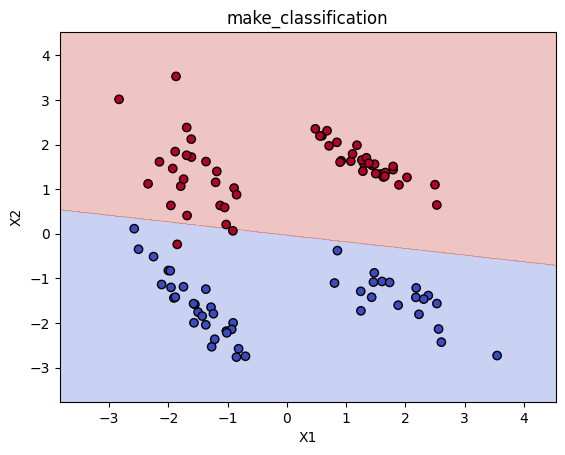

In [39]:
print("=== Dataset: make_classification ===")
X, y = make_classification(n_samples=500, n_features=2, n_classes=2, n_redundant=0,
                           n_informative=2, random_state=1, class_sep=1.5)
X_train, X_test, y_train, y_test = train_test_split(X, y.reshape(-1, 1), test_size=0.2)

model = NeuralNet(hidden_layers=[8, 16], hidden_activations=['relu', 'relu'], learning_rate=0.1, early_stopping=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc, rep, cm = evaluate_classification(y_test, y_pred)
print(rep)
plot_decision_boundary(model, X_test, y_test)
plt.title("make_classification")
plt.show()

=== Dataset: make_moons ===
0-th iteration: cost = 0.6931409043919495
100-th iteration: cost = 0.693128143073694
200-th iteration: cost = 0.6931251779105547
300-th iteration: cost = 0.6931231792142111
400-th iteration: cost = 0.6931213977416624
500-th iteration: cost = 0.6931196535412205
600-th iteration: cost = 0.6931178287772943
700-th iteration: cost = 0.693115905187995
800-th iteration: cost = 0.6931138833260231
900-th iteration: cost = 0.6931117310017114
1000-th iteration: cost = 0.6931094203140803
1100-th iteration: cost = 0.6931069297532895
1200-th iteration: cost = 0.6931042415108766
1300-th iteration: cost = 0.6931013317523411
1400-th iteration: cost = 0.6930981789350755
1500-th iteration: cost = 0.6930947631144716
1600-th iteration: cost = 0.6930910509461543
1700-th iteration: cost = 0.6930870127080654
1800-th iteration: cost = 0.6930826084810761
1900-th iteration: cost = 0.6930778016695649
2000-th iteration: cost = 0.6930725507755898
2100-th iteration: cost = 0.6930668072653

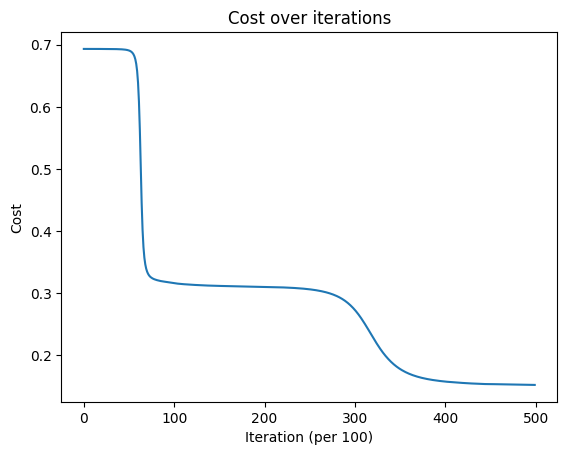

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       101
           1       0.95      0.91      0.93        99

    accuracy                           0.93       200
   macro avg       0.93      0.93      0.93       200
weighted avg       0.93      0.93      0.93       200



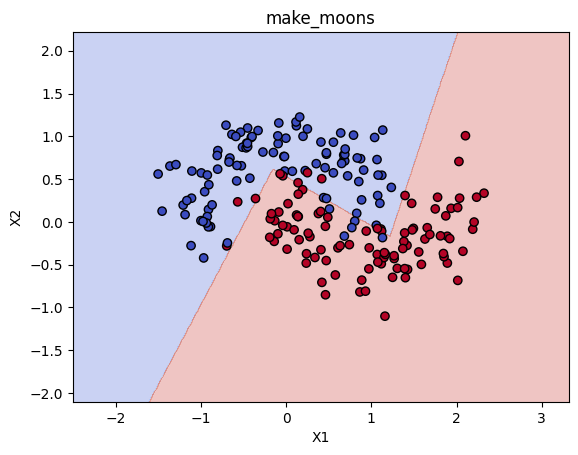

In [41]:
print("=== Dataset: make_moons ===")
X, y = make_moons(n_samples=1000, noise=0.25, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y.reshape(-1, 1), test_size=0.2)

model = NeuralNet(hidden_layers=[16, 64], hidden_activations=['relu', 'relu'], learning_rate=0.05, early_stopping=True, num_iter=50000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc, rep, cm = evaluate_classification(y_test, y_pred)
print(rep)
plot_decision_boundary(model, X_test, y_test)
plt.title("make_moons")
plt.show()